# TP MODELISATION DU CHURN

# Sommaire

1. [Import de la table préparée et Séparation Train / Test](#sect1)
2. [Standardisation des variables](#sect2)
3. [Modélisation](#sectmodel)
  - [Régression pénalisée](#sect41)
  - [Régression pénalisée (Elastic Net)](#sect42)
  - [Random Forest](#sect43)
  - [GBM (Gradient Boosting Machine)](#sect44)

In [199]:
import pandas as pd
import os
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,roc_auc_score,roc_curve,auc

import matplotlib.pyplot as plt

# 1 Chargement des données préparées <a name="sect1" ></a>

In [200]:
repertoire = "/home/jupyter/python_ml/data"
os.chdir(repertoire)
file=open("churn_prepared.pydata","rb")
data=pickle.load(file)
file.close()

In [201]:
data.shape

(3333, 20)

In [202]:
data.describe()


,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Area Code_415,Area Code_510
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.496550,0.252025
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.500063,0.434241
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,0.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,0.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,1.000000,1.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,1.000000


In [203]:
data.dtypes

Account Length      int64
Int'l Plan           bool
VMail Plan           bool
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
Area Code_415       uint8
Area Code_510       uint8
dtype: object

In [204]:
X= data.drop('Churn?',axis=1)
y=data['Churn?'].astype(int)

In [205]:
y.value_counts(normalize=True)

0    0.855086
1    0.144914
Name: Churn?, dtype: float64

In [206]:
# split Apprentissage Test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3,random_state=42)

In [207]:
X_train.shape, X_test.shape

((2333, 19), (1000, 19))

In [208]:
y_train.sum(), y_test.sum()

(338, 145)

In [209]:
y_train.mean(), y_test.mean()

(0.14487783969138449, 0.145)

# 2. Standardisation des variables <a name="sect2" ></a>

In [210]:
from sklearn.preprocessing import StandardScaler
norm=StandardScaler().fit(X_train) 
X_train = pd.DataFrame(norm.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(norm.transform(X_test), columns=X.columns)

In [211]:
X_train.describe()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Area Code_415,Area Code_510
count,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03,2.333000e+03
mean,-1.706022e-16,2.917607e-16,-9.374794e-16,-3.604299e-16,-2.691565e-16,-1.948720e-16,-5.362192e-16,1.960617e-16,3.422454e-16,-3.202658e-16,-9.569904e-17,-1.094519e-17,7.241433e-16,-2.174286e-16,-8.959590e-17,3.807975e-16,-1.330554e-16,2.588776e-17,-2.745815e-16
std,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00,1.000214e+00
min,-2.487259e+00,-3.186077e-01,-6.287567e-01,-6.014372e-01,-3.331687e+00,-5.004624e+00,-3.331755e+00,-3.942555e+00,-4.997841e+00,-3.942646e+00,-3.557234e+00,-3.436090e+00,-3.558946e+00,-3.601369e+00,-1.856517e+00,-3.601979e+00,-1.202826e+00,-1.006450e+00,-5.679457e-01
25%,-6.634062e-01,-3.186077e-01,-6.287567e-01,-6.014372e-01,-6.710391e-01,-6.624940e-01,-6.705548e-01,-6.949818e-01,-6.613366e-01,-6.953804e-01,-6.760070e-01,-6.688108e-01,-6.742155e-01,-6.451014e-01,-6.183081e-01,-6.431349e-01,-4.329515e-01,-1.006450e+00,-5.679457e-01
50%,-1.381472e-02,-3.186077e-01,-6.287567e-01,-6.014372e-01,-7.267824e-03,3.623950e-02,-7.435909e-03,1.952346e-02,-1.335321e-02,1.855747e-02,-7.867457e-03,-2.613915e-03,-9.880450e-03,2.357809e-02,-2.055720e-01,2.162742e-02,-4.329515e-01,9.935910e-01,-5.679457e-01
75%,6.607610e-01,-3.186077e-01,1.590440e+00,8.570659e-01,6.713363e-01,6.850635e-01,6.709521e-01,6.576843e-01,6.844750e-01,6.587986e-01,6.662914e-01,6.635829e-01,6.678305e-01,6.570640e-01,6.199004e-01,6.603206e-01,3.369234e-01,9.935910e-01,-5.679457e-01
max,3.558938e+00,3.138656e+00,1.590440e+00,3.117746e+00,3.172530e+00,3.230450e+00,3.172917e+00,3.177049e+00,3.475788e+00,3.176005e+00,3.902655e+00,3.840829e+00,3.900333e+00,3.437363e+00,5.572734e+00,3.436681e+00,5.726047e+00,9.935910e-01,1.760732e+00


In [212]:
X_test.describe()

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Area Code_415,Area Code_510
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.042625,0.054777,-0.049546,-0.036048,0.005136,0.026906,0.005136,-0.027554,-0.025515,-0.027542,0.025407,0.009685,0.025508,0.005031,-0.025619,0.005100,0.001258,-0.044430,0.063126
std,0.982330,1.073604,0.975114,0.993613,1.032593,1.005203,1.032595,0.975330,0.976362,0.975363,1.048096,1.009313,1.048094,0.940531,1.051659,0.940386,1.041961,0.999798,1.035559
min,-2.487259,-0.318608,-0.628757,-0.601437,-3.331687,-5.004624,-3.331755,-3.000974,-2.854511,-3.000709,-3.145916,-3.179860,-3.144294,-3.601369,-1.856517,-3.601979,-1.202826,-1.006450,-0.567946
25%,-0.638422,-0.318608,-0.628757,-0.601437,-0.652498,-0.612584,-0.652832,-0.669534,-0.661337,-0.670047,-0.647415,-0.668811,-0.648578,-0.574714,-0.618308,-0.577962,-0.432951,-1.006450,-0.567946
50%,0.011170,-0.318608,-0.628757,-0.601437,0.012200,0.036240,0.012196,-0.033330,-0.013353,-0.034412,0.060351,-0.002614,0.061458,0.058772,-0.205572,0.060731,-0.432951,-1.006450,-0.567946
75%,0.685745,-0.318608,1.590440,0.565365,0.720470,0.685063,0.720850,0.679707,0.634630,0.680102,0.793699,0.714829,0.793787,0.657064,0.619900,0.660321,0.336923,0.993591,1.760732
max,3.084237,3.138656,1.590440,3.044821,3.098366,3.130631,3.098752,3.139856,3.176719,3.139157,3.639814,3.277124,3.641733,2.733490,6.398207,2.732815,5.726047,0.993591,1.760732


# 3. Modélisation <a name="sectmodel" ></a>

In [213]:
# Import de la fonction de lift à utiliser
os.chdir('/home/jupyter/python_ml/modules/')
from fonctions_metrics import lift

## 3.1 PARAMETRER LE MODELE REG PENALISEE <a name="sect41" ></a>
Choisir ridge (L2) ou lasso (L1) ou elasticnet, avec la classe LogisticRegression
Définir une grille d'hyper param pour C
et utliser GridSearchCV pour la balayer

In [214]:
## Regression logistique avec pénalité lasso et grid search
#### on cherche par CV le meilleur C (1/alpha) le coef de regularisation

In [215]:
param = [{"C":[0.001,0.005,0.01,0.025,0.05,0.075,0.1]}]
# Instancie le modele LASSO : construction classe
lr=LogisticRegression(penalty='l1',solver='liblinear')
# Grid Search : on indique le modele et la grille de param
modeleLassoCV = GridSearchCV (lr,param,cv = 4,n_jobs=-1,scoring='roc_auc')
modeleLassoCV = modeleLassoCV.fit(X_train,y_train)
modeleLassoCV.best_params_

{'C': 0.05}

In [216]:
# Je constate que le meilleur modeles est 0.05 donc je le reinstancie 
model_LogitL1 =LogisticRegression(penalty='l1',solver='liblinear',C=0.05)
# appliquer la méthode fit() : apprend sur les données de TRAIN
model_LogitL1.fit(X_train,y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [217]:
# récupérer les coef
coef=list(model_LogitL1.coef_[0]) # c un array2d, 
len(coef) # il y a 20 
coef

[0.0,
 0.493123862492226,
 -0.2706336095164049,
 0.0,
 0.029783373672802895,
 0.0,
 0.4514350989920841,
 0.04119822220693163,
 0.0,
 0.17786344499133183,
 0.0,
 0.0,
 0.03659674429593833,
 0.0,
 -0.21295223916851927,
 0.1423141798099136,
 0.5482137410778691,
 0.0,
 0.0]

In [218]:
# combien d'élemnts non nuls ?
feature_0= [i for i in coef if i==0] #print(feature_0)
print(len(feature_0))
# PLus on baisse C, plus de colonnes s'annulent (0)

9


### Analyser les résultats et les performances 

In [219]:
# Prediction des probabilités de 1 avec 
# Colonne 1 signifie la seconde modalité du vecteur soit la proba Churn=1
probas_test = modeleLassoCV.predict_proba(X_test)[:,1]
probas_train = modeleLassoCV.predict_proba(X_train)[:,1]

In [220]:
# score: accuracy taux de bien classé global au cutoff de 0.5
print(model_LogitL1.score(X_test, y_test))
print(model_LogitL1.score(X_train,y_train))

0.868
0.8581225889412774


In [221]:
#AUC
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))

0.8222672064777328
0.8187134502923977


In [222]:
print(lift(probas_train,X_train,y_train))
print(lift(probas_test,X_test,y_test))

# Le lift à 10% : je prend les 10% plus fortes proba de churn (individus les plus risqués),
# taux de churn / taux de churn moyen 

lift at 10 percent : 3.34
3.34
lift at 10 percent : 3.66
3.66


In [223]:
#compute lift at 5%
print(lift(probas_train,X_train,y_train,p=5))
print(lift(probas_test,X_test,y_test,p=5))

lift at 5 percent : 3.61
3.61
lift at 5 percent : 4.41
4.41


In [224]:
# ENR LES RESULTATS DANS UN DICTIONNAIRE POUR POUVOIR COMPARER
model='Score Lasso'
# métriques (liste de dictionnaires)
metriques = [{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}]
metriques

lift at 5 percent : 4.41
lift at 10 percent : 3.66


[{'model': 'Score Lasso',
  'AUC_test': 0.819,
  'lift at 5': 4.41,
  'lift at 10': 3.66}]

In [225]:
# mat de confusion à un cutoff donné
pred = (probas_test > 0.14).astype(int)
print(confusion_matrix(y_test, pred))
print(pd.crosstab(y_test,pred, normalize="index"))
print(pd.crosstab(y_test,pred, normalize="columns"))

target_names = ['Fidèles','Churners']

# métriques au cutoff donné
print(classification_report(y_test,pred, target_names=target_names))
# métriques au cutoff par défaut
print(classification_report(y_test,model_LogitL1.predict(X_test), target_names=target_names))



[[582 273]
 [ 31 114]]
col_0          0         1
Churn?                    
0       0.680702  0.319298
1       0.213793  0.786207
col_0          0         1
Churn?                    
0       0.949429  0.705426
1       0.050571  0.294574
              precision    recall  f1-score   support

     Fidèles       0.95      0.68      0.79       855
    Churners       0.29      0.79      0.43       145

    accuracy                           0.70      1000
   macro avg       0.62      0.73      0.61      1000
weighted avg       0.85      0.70      0.74      1000

              precision    recall  f1-score   support

     Fidèles       0.88      0.98      0.93       855
    Churners       0.66      0.19      0.29       145

    accuracy                           0.87      1000
   macro avg       0.77      0.58      0.61      1000
weighted avg       0.85      0.87      0.83      1000



In [226]:
from fonctions_metrics import CAP_table, auc_et_roc
CAP_table(pd.Series(probas_test, index= y_test.index),y_test, stepsize=5,n=10 )

,Population,Positifs parmi la population,% positifs,Population cumulée,Positifs cumulés,% Positifs cumulés,% positifs cumulés sur le total des positifs,Lift
5,50,32,64.0,50,32,64.00,22.07,4.41
10,50,21,42.0,100,53,53.00,36.55,3.66
15,50,12,24.0,150,65,43.33,44.83,2.99
20,50,15,30.0,200,80,40.00,55.17,2.76
25,50,14,28.0,250,94,37.60,64.83,2.59
30,50,9,18.0,300,103,34.33,71.03,2.37
35,50,6,12.0,350,109,31.14,75.17,2.15
40,50,6,12.0,400,115,28.75,79.31,1.98
45,50,9,18.0,450,124,27.56,85.52,1.90
50,50,3,6.0,500,127,25.40,87.59,1.75


auc= 0.8187134502923977


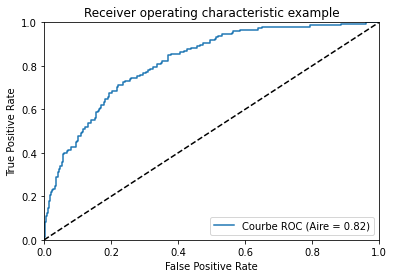

In [227]:
auc_et_roc(y_test, probas_test)

## 3.2 PARAMETRER LE MODELE REG PENALISEE ELASTICNET <a name="sect42" ></a>

In [228]:
# Régression logistique elastic net : SGDClassifier : loss = log --> logistique
# penalty = "elasticnet"
# alpha entre 1 et 1000 , et l1_ratio entre 0 et 1
from sklearn.linear_model import SGDClassifier

param = [{"alpha":(0.001,0.01,0.015,0.025,0.004,0.05,0.075,0.1,0.2),
          "l1_ratio":(0.1,0.25,0.5) }] 
sgdElasticAUCnow = GridSearchCV (SGDClassifier(loss="log", penalty="elasticnet",l1_ratio=0.25,class_weight=None), param, cv = 4,n_jobs=4,scoring='roc_auc')

cvelasticnet = sgdElasticAUCnow.fit(X_train,y_train)
cvelasticnet.best_params_



{'alpha': 0.025, 'l1_ratio': 0.5}

In [229]:
elasticnet = SGDClassifier(loss="log", penalty="elasticnet", **cvelasticnet.best_params_) ## dict va parser directement les clés comme des arguments et valeurs comme valeurs des arguments
# Apprentissage du modele
elasticnet.fit(X_train,y_train)


SGDClassifier(alpha=0.025, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.5, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [230]:
# combien d'élemnts non nuls ?
coef = list(elasticnet.coef_[0])
feature_0= [i for i in coef if i==0] #print(feature_0)
print(len(feature_0))
# PLus on baisse C, plus de colonnes s'annulent (0)

9


### Analyser les résultats et les performances (light)


In [231]:
# Prediction des probabilités de 1 avec    model_LogitL1.predict_proba(X)
probas_test = elasticnet.predict_proba(X_test)[:,1]
probas_train = elasticnet.predict_proba(X_train)[:,1]

In [232]:
#AUC
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))

0.8218475182037933
0.8193829401088929


In [233]:
# AJOUTE LES RESULTATS
model='Score elasticnet'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques

lift at 5 percent : 4.41
lift at 10 percent : 3.52


[{'model': 'Score Lasso',
  'AUC_test': 0.819,
  'lift at 5': 4.41,
  'lift at 10': 3.66},
 [{'model': 'Score elasticnet',
   'AUC_test': 0.819,
   'lift at 5': 4.41,
   'lift at 10': 3.52}]]

## 3.3 PARAMETRER LE MODELE RANDOMFOREST <a name="sect43" ></a>
Tester un modle light peu profond et un modele complexe

In [234]:
# exemple randomforest avec des rbres peu profonds
rf_light = RandomForestClassifier(     n_estimators = 300,
                                       criterion = "gini",
                                       max_features = "sqrt",
                                       max_depth = 4,
                                       min_samples_split = 40,
                                       min_samples_leaf = 30,                                                                           
                                       n_jobs = -1, # coeurs
                                       random_state = 42,
                                       class_weight="balanced"
                                     )    


In [235]:
# avec des arbres profonds et dont les feuilles avec 5 ind min
# on bloque à 100 feuilles max
rf_complex= RandomForestClassifier(     n_estimators = 300,
                                       criterion = "gini",
                                       max_features = "sqrt",
                                       max_depth = 8,
                                       min_samples_split = 10,
                                       min_samples_leaf = 5,                                                                           
                                       max_leaf_nodes = 100,
                                       n_jobs = -1, # coeurs
                                       random_state = 42,
                                       class_weight="balanced"
                                     )    

In [236]:
# Apprentissage du modele avec methode fit
rf_light.fit(X_train,y_train)
rf_complex.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [237]:
# Importance des variables Light
df=pd.DataFrame(rf_light.feature_importances_,X_train.columns.values)
df.columns=['Importance']
df.sort_values(by='Importance',ascending=False)

,Importance
Day Mins,0.212086
Day Charge,0.204832
CustServ Calls,0.200186
Int'l Plan,0.126640
Eve Mins,0.037598
VMail Message,0.035982
Eve Charge,0.034412
VMail Plan,0.028650
Intl Calls,0.023216
Intl Charge,0.023067


In [238]:
# Importance des variables Complex
df=pd.DataFrame(rf_complex.feature_importances_,X_train.columns.values)
df.columns=['Importance']
df.sort_values(by='Importance',ascending=False)

,Importance
CustServ Calls,0.189486
Day Mins,0.156142
Day Charge,0.151496
Int'l Plan,0.101870
Eve Mins,0.052318
Eve Charge,0.048065
VMail Message,0.034555
Intl Charge,0.032580
Intl Calls,0.030972
Intl Mins,0.028597


### Analyser les résultats et les performances (light)

In [239]:
# Prediction des probabilités de 1 ( array2d ) avec fonction predict_proba
probas_test = rf_light.predict_proba(X_test)[:,1]
probas_train = rf_light.predict_proba(X_train)[:,1]

In [240]:
#AUC sur train et test avec roc_auc_score
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))
# un peu de surapprentissage mais peu ce qui est normal car ce sont des arbres peu profonds

0.9271803769779478
0.8892760637225247


In [241]:
print(lift(probas_train,X_train,y_train))
print(lift(probas_test,X_test,y_test))

lift at 10 percent : 5.8
5.8
lift at 10 percent : 5.17
5.17


In [242]:
# AJOUTE LES RESULTATS
model='rf light'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques

lift at 5 percent : 6.07
lift at 10 percent : 5.17


[{'model': 'Score Lasso',
  'AUC_test': 0.819,
  'lift at 5': 4.41,
  'lift at 10': 3.66},
 [{'model': 'Score elasticnet',
   'AUC_test': 0.819,
   'lift at 5': 4.41,
   'lift at 10': 3.52}],
 [{'model': 'rf light',
   'AUC_test': 0.889,
   'lift at 5': 6.07,
   'lift at 10': 5.17}]]

In [243]:
# Prediction des probabilités de 1 ( array2d ) avec fonction predict_proba
probas_test = rf_complex.predict_proba(X_test)[:,1]
probas_train = rf_complex.predict_proba(X_train)[:,1]

In [244]:
#AUC sur train et test avec roc_auc_score
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))
# ! Surapprentissage ce qui est normal car ce sont des arbres profonds

0.9898948554819
0.9065295422464207


In [245]:
# AJOUTE LES RESULTATS
model='rf complex'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques
# conclusion  le modele RF est plus predictif mais moins confiance dans sa capacité à etre robuste à moyen terme

lift at 5 percent : 6.62
lift at 10 percent : 6.21


[{'model': 'Score Lasso',
  'AUC_test': 0.819,
  'lift at 5': 4.41,
  'lift at 10': 3.66},
 [{'model': 'Score elasticnet',
   'AUC_test': 0.819,
   'lift at 5': 4.41,
   'lift at 10': 3.52}],
 [{'model': 'rf light',
   'AUC_test': 0.889,
   'lift at 5': 6.07,
   'lift at 10': 5.17}],
 [{'model': 'rf complex',
   'AUC_test': 0.907,
   'lift at 5': 6.62,
   'lift at 10': 6.21}]]

## 3.4 PARAMETRER LE MODELE GRADIENT BOOSTING MACHINE <a name="sect44" ></a>


In [246]:
from sklearn.ensemble import GradientBoostingClassifier

In [247]:
gbt_noRand05=GradientBoostingClassifier(loss='deviance', learning_rate=0.05,
                           n_estimators=500,
                           subsample=1.0, min_samples_split=20, min_samples_leaf=10,
                           max_depth=4,
                                       random_state=42)

In [248]:
# Apprentissage du modele
gbt_noRand05.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Analyse du nb iterations optimal en affichant la fonction de perte sur le test

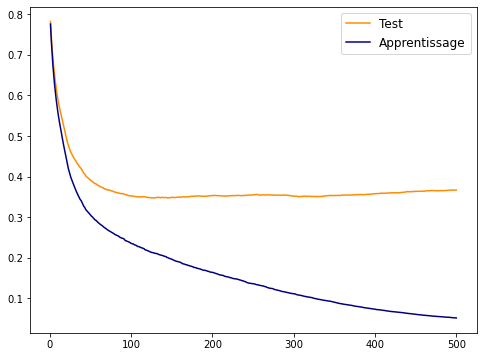

In [249]:
niter=500
iter = np.arange(niter) + 1
test_deviance = np.zeros((niter,), dtype=np.float64)
# staged_decision_functio : décision fonction à chaque iteration
for i, y_pred in enumerate(gbt_noRand05.staged_decision_function(X_test)):
    # clf.loss_ assumes that y_test[i] in {0, 1}
    test_deviance[i] = gbt_noRand05.loss_(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Erreur sur le test (evolution deviance)
plt.plot(iter,test_deviance,label='Test',color='darkorange')
        # min vers 100 
# Erreur sur apprentissage (evolution deviance)
plt.plot(iter,gbt_noRand05.train_score_,label='Apprentissage',color='navy')    
# Diminution de l'erreur rapport modele precedant (par rapport au oob)
#plt.plot(iter,gbt_noRand05.oob_improvement_)
plt.legend(loc="upper right", fontsize=12)


In [250]:
# algo avec randomisation subsample=0.5 et max_feature = racine(nb variable)

gbt_Rand=GradientBoostingClassifier(loss='deviance', learning_rate=0.05,
                           n_estimators=500,
                           subsample=0.5, min_samples_split=30, min_samples_leaf=20,
                           min_weight_fraction_leaf=0.005,
                           max_depth=3,max_leaf_nodes=12,max_features="sqrt", random_state=42)
# Apprentissage du modele
gbt_Rand.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=12,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=20, min_samples_split=30,
                           min_weight_fraction_leaf=0.005, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

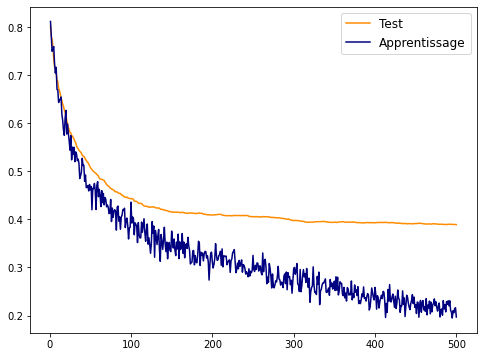

In [251]:
niter=500
iter = np.arange(niter) + 1
test_deviance = np.zeros((niter,), dtype=np.float64)
# staged_decision_functio : décision fonction à chaque iteration
for i, y_pred in enumerate(gbt_Rand.staged_decision_function(X_test)):
    # clf.loss_ assumes that y_test[i] in {0, 1}
    test_deviance[i] = gbt_Rand.loss_(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Erreur sur le test (evolution deviance)
plt.plot(iter,test_deviance,label='Test',color='darkorange')
        # min vers 100 
# Erreur sur apprentissage (evolution deviance)
plt.plot(iter,gbt_Rand.train_score_,label='Apprentissage',color='navy')    
# Diminution de l'erreur rapport modele precedant (par rapport au oob)
#plt.plot(iter,gbt_noRand05.oob_improvement_)
plt.legend(loc="upper right", fontsize=12)

In [252]:
# algo early stopping (150 itération)

gbt_Rand150=GradientBoostingClassifier(loss='deviance', learning_rate=0.05,
                           n_estimators=150,
                           subsample=0.5, min_samples_split=30, min_samples_leaf=20,
                           min_weight_fraction_leaf=0.005,
                           max_depth=3,max_leaf_nodes=12,max_features="sqrt", random_state=42)
# Apprentissage du modele
gbt_Rand150.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=12,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=20, min_samples_split=30,
                           min_weight_fraction_leaf=0.005, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

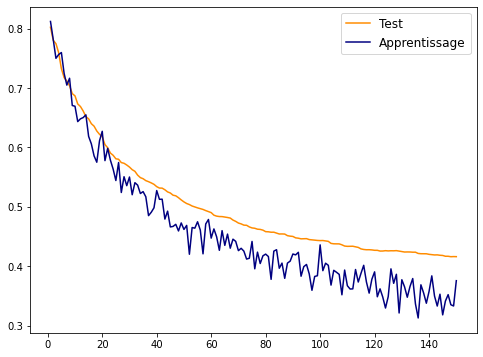

In [253]:
niter=150
iter = np.arange(niter) + 1
test_deviance = np.zeros((niter,), dtype=np.float64)
# staged_decision_functio : décision fonction à chaque iteration
for i, y_pred in enumerate(gbt_Rand150.staged_decision_function(X_test)):
    # clf.loss_ assumes that y_test[i] in {0, 1}
    test_deviance[i] = gbt_Rand150.loss_(y_test, y_pred)

plt.figure(figsize=(8, 6))
# Erreur sur le test (evolution deviance)
plt.plot(iter,test_deviance,label='Test',color='darkorange')
        # min vers 100 
# Erreur sur apprentissage (evolution deviance)
plt.plot(iter,gbt_Rand150.train_score_,label='Apprentissage',color='navy')    
# Diminution de l'erreur rapport modele precedant (par rapport au oob)
#plt.plot(iter,gbt_noRand05.oob_improvement_)
plt.legend(loc="upper right", fontsize=12)

### Analyser les résultats et les performances (light) 

In [254]:
# Prediction des probabilités de 1 , array2d
probas_test = gbt_noRand05.predict_proba(X_test)[:,1]
probas_train = gbt_noRand05.predict_proba(X_train)[:,1]


In [255]:
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))


0.9999050881641974
0.9025448679169187


In [256]:
# AJOUTE LES RESULTATS
model='gbm no rand'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques
# conclusion  le modele RF est plus predictif mais moins confiance dans sa capacité à etre robuste à moyen terme


lift at 5 percent : 6.9
lift at 10 percent : 6.48


[{'model': 'Score Lasso',
  'AUC_test': 0.819,
  'lift at 5': 4.41,
  'lift at 10': 3.66},
 [{'model': 'Score elasticnet',
   'AUC_test': 0.819,
   'lift at 5': 4.41,
   'lift at 10': 3.52}],
 [{'model': 'rf light',
   'AUC_test': 0.889,
   'lift at 5': 6.07,
   'lift at 10': 5.17}],
 [{'model': 'rf complex',
   'AUC_test': 0.907,
   'lift at 5': 6.62,
   'lift at 10': 6.21}],
 [{'model': 'gbm no rand',
   'AUC_test': 0.903,
   'lift at 5': 6.9,
   'lift at 10': 6.48}]]

In [257]:
# Prediction des probabilités de 1 , array2d
probas_test = gbt_Rand.predict_proba(X_test)[:,1]
probas_train = gbt_Rand.predict_proba(X_train)[:,1]


In [258]:
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))


0.9861117290267088
0.9087638636821941


In [259]:
# AJOUTE LES RESULTATS
model='gbm rand'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques
# conclusion  le modele RF est plus predictif mais moins confiance dans sa capacité à etre robuste à moyen terme


lift at 5 percent : 6.9
lift at 10 percent : 6.21


[{'model': 'Score Lasso',
  'AUC_test': 0.819,
  'lift at 5': 4.41,
  'lift at 10': 3.66},
 [{'model': 'Score elasticnet',
   'AUC_test': 0.819,
   'lift at 5': 4.41,
   'lift at 10': 3.52}],
 [{'model': 'rf light',
   'AUC_test': 0.889,
   'lift at 5': 6.07,
   'lift at 10': 5.17}],
 [{'model': 'rf complex',
   'AUC_test': 0.907,
   'lift at 5': 6.62,
   'lift at 10': 6.21}],
 [{'model': 'gbm no rand',
   'AUC_test': 0.903,
   'lift at 5': 6.9,
   'lift at 10': 6.48}],
 [{'model': 'gbm rand',
   'AUC_test': 0.909,
   'lift at 5': 6.9,
   'lift at 10': 6.21}]]

In [260]:
# Prediction des probabilités de 1 , array2d
probas_test = gbt_Rand150.predict_proba(X_test)[:,1]
probas_train = gbt_Rand150.predict_proba(X_train)[:,1]


In [261]:
print(roc_auc_score(y_train,probas_train))
print(roc_auc_score(y_test,probas_test))


0.9488855274280376
0.909957652752571


In [262]:
# AJOUTE LES RESULTATS
model='gbm rand 150'
# métriques (liste de dictionnaires)
metriques.append([{'model':model,'AUC_test':round(roc_auc_score(y_test,probas_test),3),'lift at 5':lift(probas_test,X_test,y_test,p=5),'lift at 10':lift(probas_test,X_test,y_test,p=10)}])
metriques
# conclusion  le modele RF est plus predictif mais moins confiance dans sa capacité à etre robuste à moyen terme


lift at 5 percent : 6.76
lift at 10 percent : 6.21


[{'model': 'Score Lasso',
  'AUC_test': 0.819,
  'lift at 5': 4.41,
  'lift at 10': 3.66},
 [{'model': 'Score elasticnet',
   'AUC_test': 0.819,
   'lift at 5': 4.41,
   'lift at 10': 3.52}],
 [{'model': 'rf light',
   'AUC_test': 0.889,
   'lift at 5': 6.07,
   'lift at 10': 5.17}],
 [{'model': 'rf complex',
   'AUC_test': 0.907,
   'lift at 5': 6.62,
   'lift at 10': 6.21}],
 [{'model': 'gbm no rand',
   'AUC_test': 0.903,
   'lift at 5': 6.9,
   'lift at 10': 6.48}],
 [{'model': 'gbm rand',
   'AUC_test': 0.909,
   'lift at 5': 6.9,
   'lift at 10': 6.21}],
 [{'model': 'gbm rand 150',
   'AUC_test': 0.91,
   'lift at 5': 6.76,
   'lift at 10': 6.21}]]